# ENet -  Real Time Semantic Segmentation

In this notebook, we have reproduced the ENet paper. <br/>
Link to the paper: https://arxiv.org/pdf/1606.02147.pdf <br/>
Link to the repository: https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation


Star and Fork!


**ALL THE CODE IN THIS NOTEBOOK ASSUMES THE USAGE OF THE <span style="color:blue;">CAMVID</span> DATASET**

## Install the dependencies and Import them

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image

## Download the CamVid dataset 

## Create the ENet model

We decided to to split the model to three sub classes:

1) Initial block  

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck -  class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [3]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  #maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [4]:
class UBNeck(nn.Module):
    
  # Upsampling bottleneck:
  #     Bottleneck Input
  #        /        \
  #       /          \
  # conv2d-1x1     convTrans2d-1x1
  #      |             | PReLU
  #      |         convTrans2d-3x3
  #      |             | PReLU
  #      |         convTrans2d-1x1
  #      |             |
  # maxunpool2d    Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  #  Params: 
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        # This layer used for Upsampling
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # summing the main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [5]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
      
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  # maxpooling2d   conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-3x3
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [6]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [ ]:
class encoder(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)

        return x, i1,i2
        
        

In [ ]:
class decoder(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C

        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
    def forward(self, x, i1, i2):
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        
        return x

In [ ]:
class ENet(nn.Module):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        self.encoder = encoder(C)
        
        # Create the decoder
        self.decoder = decoder(C)

    def forward(self, x):
        # Pass input through the encoder
        encoder_output, i1, i2 = self.encoder(x)

        # Pass encoder output and intermediate feature maps to the decoder
        decoder_output = self.decoder(encoder_output, i1, i2)

        return decoder_output


## Instantiate the ENet model

Move the model to cuda if available

In [8]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

enet = ENet(2)
enet = enet.to(device)

print(device)

cuda:0


## Define the loader that will load the input and output images

In [9]:
def loader(training_path, segmented_path, batch_size, h=512, w=512):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    road_idx = 0
    while(1):
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
            
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            img = plt.imread(training_path + filenames_t[jj])
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)
            
            label_img = cv2.imread(segmented_path +filenames_s[jj], cv2.IMREAD_UNCHANGED)            
            road_mask = (label_img == road_idx).astype(np.uint8)
            road_mask = cv2.resize(road_mask, (h, w), cv2.INTER_NEAREST)
            labels.append(road_mask)
         
        inputs = np.stack(inputs, axis=2)
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        labels = torch.tensor(labels)
        #print('label ', labels.shape)
        
        yield inputs, labels

## IoU functions

In [10]:
def intersection_over_union(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()

    iou = intersection / union if union > 0 else 0.0
    return iou

def mean_iou(predictions, targets, num_classes):
    class_iou = [0] * num_classes
    
    for class_idx in range(num_classes):
        pred_mask = (predictions == class_idx)
        true_mask = (targets == class_idx)
        class_iou[class_idx] = intersection_over_union(pred_mask, true_mask)

    mean_iou_value = sum(class_iou) / num_classes
    
    return mean_iou_value


def calculate_mIoU(model, inputs, labels, device, num_classes):
    model.eval()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)

        batch_iou = mean_iou(predictions, labels, num_classes)
        mIoU = batch_iou
    return mIoU




## Define the class weights

In [11]:
def get_class_weights(pipe,num_classes, c=1.02):
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [12]:
pipe = loader('/kaggle/input/camvid-segmap/CamVid/train/', '/kaggle/input/camvid-segmap/CamVid/trainannot/', batch_size='all')



In [13]:
class_weights = get_class_weights(pipe,2)
print(class_weights)


/tmp/ipykernel_26/3767593591.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels)


[1.87286398 3.46680241]


## Define the Hyperparameters

In [32]:
lr = 5e-4
batch_size = 10

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))

optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


epochs = 2000
save_every = 100
eval_every = 50



## Training loop

In [33]:
train_losses = []
eval_losses = []
eval_acc = []
test_losses = []
test_acc = []

batch_size = 10
bc_train = 367 // batch_size # mini_batch train
bc_eval = 101 // batch_size  # mini_batch validation
bc_test = 233 // batch_size


# Define pipeline objects
pipe = loader('/kaggle/input/camvid-segmap/CamVid/train/', '/kaggle/input/camvid-segmap/CamVid/trainannot/', batch_size)
eval_pipe = loader('/kaggle/input/camvid-segmap/CamVid/val/', '/kaggle/input/camvid-segmap/CamVid/valannot/', batch_size)


# Train loop
def train (model,epochs, pipe, eval_pipe, criterion, optimizer, scheduler, device):
    for e in range(1, epochs+1):

        if (epochs<60):
            for param in enet.decoder.parameters():
                param.requires_grad = False
    
        train_loss = 0
        print ('-'*15,'Epoch %d' % e, '-'*15)
    
        enet.train()
    
        for _ in tqdm(range(bc_train)):
            X_batch, mask_batch = next(pipe)
        
            # assign data to cpu/gpu
            X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

            optimizer.zero_grad()

            out = enet(X_batch.float())
            #print(mask_batch.shape)
            #print( 'pred ',out.shape)
        
            # loss calculation
            loss = criterion(out, mask_batch.long())
            # update weights
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss/batch_size)
    
    
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0
            cum_eval_iou =0
        
            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)
                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                out = enet(inputs)
                loss = criterion(out, labels.long())
                eval_loss += loss.item()
            
                cum_eval_iou += calculate_mIoU(enet, inputs, labels, device, 2)            
   
        eval_losses.append(eval_loss/batch_size)
        eval_acc.append(cum_eval_iou/batch_size)
        print ('Epoch {}/{}...'.format(e, epochs),
                'train_Loss {:6f}'.format(train_losses[-1]),
                'eval_Loss {:6f}'.format(eval_losses[-1]),
                'eval_acc {:6f}'.format(eval_acc[-1]))
        
        scheduler.step(eval_loss/bc_eval)
        if e % save_every == 0:
            checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict(),
            'train_error' :train_losses,
            'val_error' : eval_losses,
            'iou_trend' : eval_acc,
            
            }
            torch.save(checkpoint, './ckpt-enet-camvid-{}-{}.pth'.format(e, train_loss))
            print ('Model saved!')
            
        print(f'current learning rate: {optimizer.param_groups[0]["lr"]}')
        
        print ('Epoch {}/{}...'.format(e, epochs),
           'Total Mean train Loss: {:6f}'.format(sum(train_losses) / e))
    return train_losses, eval_losses, eval_acc

In [34]:
train_losses, eval_losses, eval_acc = train(enet,epochs, pipe, eval_pipe, criterion, optimizer, scheduler, device )

--------------- Epoch 1 ---------------


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch 1/2000... train_Loss 2.138586 eval_Loss 13.067693 eval_acc 0.151923
current learning rate: 5e-08
Epoch 1/2000... Total Mean train Loss: 2.138586
--------------- Epoch 2 ---------------


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch 2/2000... train_Loss 2.147134 eval_Loss 13.495261 eval_acc 0.154634
current learning rate: 5e-08
Epoch 2/2000... Total Mean train Loss: 2.142860
--------------- Epoch 3 ---------------


 22%|██▏       | 8/36 [00:09<00:31,  1.13s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Training and Validation losses trend')

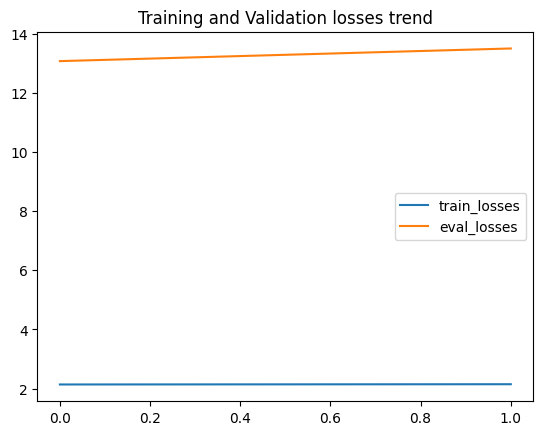

In [35]:

plt.plot(train_losses, label='train_losses')
plt.plot(eval_losses, label = 'eval_losses')
plt.legend(frameon = True)
plt.title('Training and Validation losses trend')



In [ ]:
test_pipe = loader('/kaggle/input/camvid-segmap/CamVid/test/', '/kaggle/input/camvid-segmap/CamVid/testannot/', batch_size)


In [ ]:

def test_model(model, epochs,testloaders, criterion, optimizer, scheduler,device):
    
    for e in range(1,epochs+1):
        enet.to(device)
        with torch.no_grad():
            enet.eval()
            
            test_loss = 0
        cum_test_iou = 0
        # test loop
        for _ in tqdm(range(bc_test)):
            inputs, labels = next(test_pipe)
                
            inputs, labels = inputs.to(device), labels.to(device)
                    
            out = enet(inputs)
            loss = criterion(out, labels.long())
            test_loss += loss.item()
            cum_test_iou += calculate_IoU(enet, inputs, labels, device)
          
            #print ('testLoss {:6f}'.format(test_loss))
        
        test_losses.append(test_loss/bc_test)
        test_acc.append(cum_test_iou/bc_test)
        
        print ('Epoch {}/{}...'.format(e, epochs),
                'eval_Loss {:6f}'.format(test_loss),
                'test_acc{:4f}'.format(test_acc[-1]))
    return test_losses, test_acc
        
      

In [ ]:
test_losses, test_acc = test_model(enet, epochs,test_pipe, criterion, optimizer, scheduler, device)

In [ ]:
plt.plot(train_losses, label='train_losses')
plt.plot(eval_losses, label='valid_losses')

# Move the test_losses tensor to the CPU before plotting
# Convert the test_losses list to a NumPy array before plotting
plt.plot(np.array(test_losses), label='test_losses')

plt.legend(frameon=True)
plt.title('Training, Validation, and Test Losses trend')
plt.show()


In [ ]:

plt.plot(eval_acc, label = 'val_accuracy')
plt.plot(test_acc, label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('IoU')
plt.legend(frameon= True)
plt.title('Validation and Test Accuracy trend')



## Infer using the trained model

Get the PreTrained ENet model

In [ ]:
def decode_segmap(image):
    road_color = [255, 0, 255]  # Magenta for road
    non_road_color = [255, 0, 0]  # Red for non-road

    # Create an RGB image with all pixels set to the non-road color
    rgb = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8) * non_road_color

    # Set pixels belonging to the road to the road color
    rgb[image == 1] = road_color

    return rgb

In [ ]:
def show_images(images, in_row=True):
    '''
    Helper function to show 3 images
    '''
    total_images = len(images)

    rc_tuple = (1, total_images)
    if not in_row:
        rc_tuple = (total_images, 1)
    
    #figure = plt.figure(figsize=(20, 10))
    for ii in range(len(images)):
        plt.subplot(*rc_tuple, ii+1)
        plt.title(images[ii][0])
        plt.axis('off')
        plt.imshow(images[ii][1])
    plt.show()

In [ ]:
h = 512
w = 512

checkpoint = torch.load('')
    
# Assuming the dataset is camvid
enet = ENet(2)
enet = enet.to(device)
state_dict = torch.load('./ckpt-enet-camvid.pth')['state_dict']
enet.load_state_dict(state_dict)

tmg_ = plt.imread(image_path)
tmg_ = cv2.resize(tmg_, (h, w), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2)
tmg = tmg.to(device)

with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)
    
b_ = out1.data.max(0)[1].cpu().numpy()

decoded_segmap = decode_segmap(b_)

smg_ = Image.open('/content/training/semantic/' + fname)
smg_ = cv2.resize(np.array(smg_), (512, 512), cv2.INTER_NEAREST)
gt_path = FLAGS.image_path.replace('test','testannot') 
gt = plt.imread(gt_path)
gt = cv2.resize(gt, (h, w), cv2.INTER_NEAREST)

images = {
 0 : ['Input Image', tmg_],
 1 : ['Predicted Segmentation', decoded_segmap],
 2 : ['ground truth', gt]
}

show_images(images)


## Save the model checkpoint

In [ ]:
# Save the parameters
checkpoint = {
    'epochs' : e,
    'state_dict' : enet.state_dict()

}
torch.save(checkpoint, 'ckpt-enet-camvid-1.pth')

## Save the entire model

In [ ]:
# Save the model
torch.save(enet, '/model.pt')

## IoU Calculation

In [ ]:


#def mean_iou(predictions, targets, num_classes):
    #class_iou = [0] * num_classes
    
    #for class_idx in range(num_classes):
        #pred_mask = (predictions == class_idx)
        #true_mask = (targets == class_idx)
        #class_iou[class_idx] = intersection_over_union(pred_mask, true_mask)

    #mean_iou_value = sum(class_iou) / num_classes
    
    #return mean_iou_value

In [ ]:
validation_path = ''
segmentation_path = ''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs, labels = pipe(validation_path, segmentation_path)
IoU_eval = calculate_mIoU(enet, inputs, labels, device, 2)
print("road IoU on camvid", mIoU_eval)
